Import package 
===
---

In [1]:
import os 
import torch 

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST



Setup variable
===
---

In [2]:
PATH_DATASETS = os.path.abspath(".") + "/datasets"
SAVE_PATH = os.path.abspath(".") + "/model"
BATCH_SIZE = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Load MNIST datasets
===
----

In [3]:
if not os.path.exists(PATH_DATASETS):
    os.mkdir(PATH_DATASETS)
trains_MNIST = MNIST(PATH_DATASETS, train=True, download=True, 
                     transform=transforms.ToTensor())

In [4]:
test_MNITST = MNIST(PATH_DATASETS, train=False, download=True, transform=transforms.ToTensor())

In [5]:
print(trains_MNIST.data.shape, test_MNITST.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


Build model architecture
===
----

In [6]:
import math

def conv_width(W, F, P, S):
    return math.floor(((W - F + 2 * P) / S) + 1)

def conv_output_volume(W, F, P, S, out):
    return conv_width(W, F, P, S) ** 2 * out

def conv_parameter_count(F, C, out):
    return F ** 2 * C * out

def pool_width(W, F, P, S):
    return conv_width(W, F, P, S)

def pool_output_volume(W, F, P, S, filter_count):
    return conv_output_volume(W, F, P, S, filter_count) 

def pool_parameter_count(W, F, S):
    return 0

def conv_pool_width(W, F, P, S, F2, P2, S2, n):
    for _ in range(n):
        W = pool_width(conv_width(W, F, P, S), F2, P2, S2)
    
    return W


In [7]:
print(conv_width(28, 5, 0, 1))
print(conv_width(227, 11, 0, 4), conv_output_volume(227, 11, 0, 4, 96), conv_parameter_count(11, 3, 96))
print(math.floor((227-11)/4)+1, 55*55*96, (11*11*3)*96)

24
55 290400 34848
55 290400 34848


In [8]:
c1_width = conv_width(28, 5, 2, 1); print(c1_width)
p1_width = pool_width(c1_width, 2, 0, 2); print(p1_width)
c2_width = conv_width(p1_width, 5, 2, 1); print(c2_width)
p2_out = pool_output_volume(c2_width, 2, 0, 2, 32)

p2_out, 7*7*32

28
14
14


(1568, 1568)

In [9]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2, stride=1),
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)    
        )
        
        self.fc = nn.Linear(7 * 7 * 32, num_classes)
    
    def forward(self, x):
        out:torch.Tensor = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = F.log_softmax(out, dim=1)
        return out 

model = ConvNet().to(device)
model
        

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [10]:
epochs = 10
lr = 0.1

train_loader = DataLoader(trains_MNIST, batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train() 
loss_list = []
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 10 == 0:
            loss_list.append(loss.item())
            batch = (batch_idx + 1) * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * (batch_idx + 1) / len(train_loader))
            print(
                f"Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f})"
                f" Loss: {loss.item():.6f}"
            )

Epoch 1: [10000 / 60000] (17) Loss: 1.981938
Epoch 1: [20000 / 60000] (33) Loss: 2.036442
Epoch 1: [30000 / 60000] (50) Loss: 1.460358
Epoch 1: [40000 / 60000] (67) Loss: 1.061409
Epoch 1: [50000 / 60000] (83) Loss: 0.748050
Epoch 1: [60000 / 60000] (100) Loss: 0.395955
Epoch 2: [10000 / 60000] (17) Loss: 0.389908
Epoch 2: [20000 / 60000] (33) Loss: 0.278883
Epoch 2: [30000 / 60000] (50) Loss: 0.296321
Epoch 2: [40000 / 60000] (67) Loss: 0.308953
Epoch 2: [50000 / 60000] (83) Loss: 0.304467
Epoch 2: [60000 / 60000] (100) Loss: 0.203171
Epoch 3: [10000 / 60000] (17) Loss: 0.187305
Epoch 3: [20000 / 60000] (33) Loss: 0.198267
Epoch 3: [30000 / 60000] (50) Loss: 0.206173
Epoch 3: [40000 / 60000] (67) Loss: 0.225707
Epoch 3: [50000 / 60000] (83) Loss: 0.212474
Epoch 3: [60000 / 60000] (100) Loss: 0.151517
Epoch 4: [10000 / 60000] (17) Loss: 0.135591
Epoch 4: [20000 / 60000] (33) Loss: 0.134041
Epoch 4: [30000 / 60000] (50) Loss: 0.149534
Epoch 4: [40000 / 60000] (67) Loss: 0.179274
Epoch 4

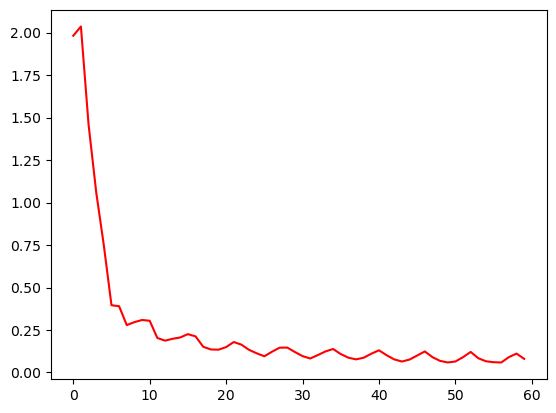

In [11]:
import matplotlib.pyplot as plt 
plt.plot(loss_list, 'r')

In [12]:
test_loader = DataLoader(test_MNITST, shuffle=False, batch_size=BATCH_SIZE)

model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        test_loss += F.nll_loss(output, target).item()
        
        output = model(data)
        
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()

test_loss /= len(test_loader.dataset)

batch = batch_idx * len(data)
data_count = len(test_loader.dataset)
percentage = 100. * correct / data_count
print(
    f"Average Loss: {test_loss:.4f}, Accurracy: {correct/data_count}" 
    f"({percentage:.2f}%)"
)

Average Loss: 0.0001, Accurracy: 0.9749(97.49%)


In [13]:
predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_MNITST[i][0], test_MNITST[i][0]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))

print("actuala   :", test_MNITST.targets[0: 20].numpy())
print("prediction: ", ' '.join(predictions[0:20]))

actuala   : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4


In [14]:
import numpy as np

i = 17
data = test_MNITST[i][0]
data = data.reshape(1, *(data.shape)).to(device)

print(data.shape)
prediction = torch.softmax(model(data), dim=1)
print(f"0~9: {np.around(prediction.cpu().detach().numpy(), 2)}")
print(f"0~9: {np.argmax(prediction.cpu().detach().numpy(), axis=-1)}")

torch.Size([1, 1, 28, 28])
0~9: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
0~9: [7]


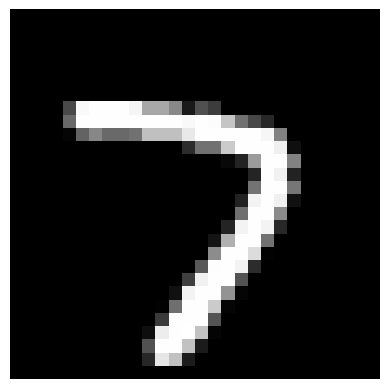

In [15]:
img = test_MNITST[i][0]
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.axis("off")
plt.show()

In [16]:
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

torch.save(model, SAVE_PATH + "/cnn_model.pth")

In [17]:
MODEL_PATH = SAVE_PATH + "/cnn_model.pth"
model = torch.load(MODEL_PATH)

In [18]:
from skimage import io 
from skimage.transform import resize

In [19]:
no = 9

upload_file = f'./myDigits/{no}.png' 
img1 = io.imread(upload_file, as_gray=True)

data_shape = data.shape 
image_resize = resize(img1, data_shape[2:], anti_aliasing=True)
x1 = image_resize.reshape(*data_shape)

x1 = 1.0 - x1
for i in range(x1[0][0].shape[0]):
    for j in range(x1[0][0].shape[0]):
        print(f"{x1[0][0][i][j]:.4f}", end=' ')
    print()

0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0000 0.0001 0.0007 0.0127 0.0322 0.0294 0.0286 0.0300 0.0287 0.0222 0.0015 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0038 0.0521 0.3177 0.5352 0.7868 0.7620 0.7551 0.7675 0.7554 0.6823 0.2691 0.0049 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 0.0744 0.6630 0.6394 0.9639 0.9995 0.9996 0.9988 0.9982 0.9981 0.9965 0.8480 0.1256 0.0005 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0

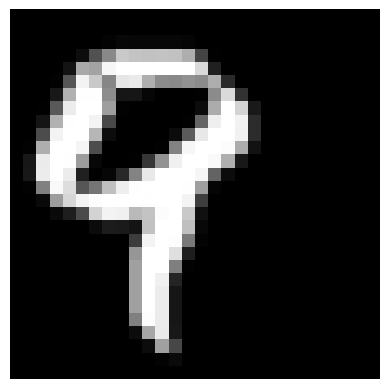

In [20]:
plt.imshow(x1.reshape(28, 28), cmap='gray')
plt.axis("off")
plt.show()

In [23]:
X2 = x1[0][0].copy()
X2[X2>0.1]=1
print(type(X2), X2[0].shape)
# 將轉換後二維內容顯示出來，隱約可以看出數字為 5
text_image=[]
for i in range(X2.shape[0]):
    text_image.append(''.join(X2[i].astype(int).astype(str)))
text_image

<class 'numpy.ndarray'> (28,)


['0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000001111111110000000000000',
 '0000011111111111000000000000',
 '0000111111111111100000000000',
 '0000111100000001110000000000',
 '0001111100000001110000000000',
 '0001111100000011111000000000',
 '0011111000000111111000000000',
 '0011111000001111110000000000',
 '0011110000111111100000000000',
 '0011110011111111000000000000',
 '0011111111111110000000000000',
 '0001111111111110000000000000',
 '0000111111111100000000000000',
 '0000000110111100000000000000',
 '0000000001111100000000000000',
 '0000000001111100000000000000',
 '0000000001111000000000000000',
 '0000000001111000000000000000',
 '0000000001110000000000000000',
 '0000000001110000000000000000',
 '0000000001110000000000000000',
 '0000000000110000000000000000',
 '0000000000011000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000']

In [24]:
# 讀取影像並轉為單色
for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = io.imread(uploaded_file, as_gray=True)

    # 縮為 (28, 28) 大小的影像
    image_resized = resize(image1, tuple(data_shape)[2:], anti_aliasing=True)    
    X1 = image_resized.reshape(*data_shape) 
    
    # 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
    X1 = 1.0-X1
    
    X1 = torch.FloatTensor(X1).to(device)
    
    # 預測
    predictions = torch.softmax(model(X1), dim=1)
    # print(np.around(predictions.cpu().detach().numpy(), 2))
    print(f'actual/prediction: {i} {np.argmax(predictions.detach().cpu().numpy())}')

actual/prediction: 0 8
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 3
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 5
actual/prediction: 7 7
actual/prediction: 8 8
actual/prediction: 9 7


In [25]:
for name, module in model.named_children():
    print(f'{name}: {module}')

layer1: Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
layer2: Sequential(
  (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
fc: Linear(in_features=1568, out_features=10, bias=True)
